## Based on https://github.com/chkwon/TrafficAssignment.jl

In [1]:
include("Julia_files/load_network_uni_class.jl")

using Graphs

#Importing parameters
using PyCall
unshift!(PyVector(pyimport("sys")["path"]), "");
@pyimport parameters_julia

out_dir = parameters_julia.out_dir
files_ID = parameters_julia.files_ID
month_w = parameters_julia.month_w
year = parameters_julia.year
instances_1 = parameters_julia.instances_ID


#instance1 = instances_1[3]

function create_graph(start_node, end_node)
    @assert Base.length(start_node)==Base.length(end_node)

    no_node = max(maximum(start_node), maximum(end_node))
    no_arc = Base.length(start_node)

    graph = simple_inclist(no_node)
    for i=1:no_arc
        add_edge!(graph, start_node[i], end_node[i])
    end
    return graph
end

function get_vector(state, origin, destination, link_dic)
    current = destination
    parent = -1
    x = zeros(Int, maximum(link_dic))

    while parent != origin
        parent = state.parents[current]

        link_idx = link_dic[parent,current]

        if link_idx != 0
            x[link_idx] = 1
        end

        current = parent
    end

    return x
end



get_vector (generic function with 1 method)

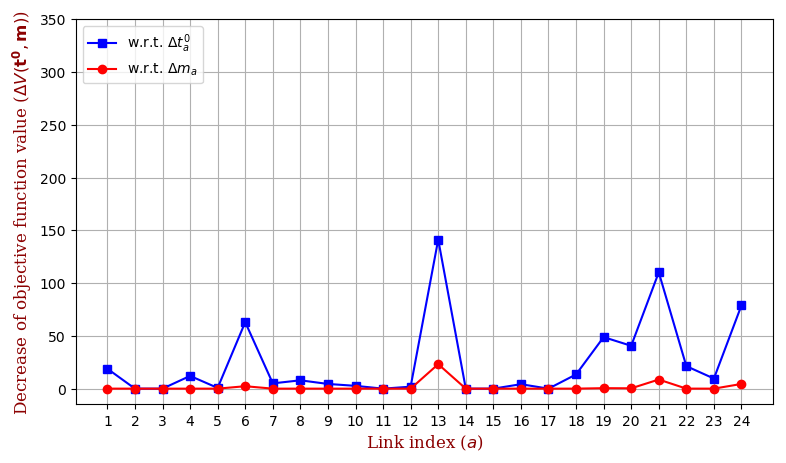

link_idx = 1 finished
-------------------------------------------
link_idx = 2 finished
-------------------------------------------
link_idx = 3 finished
-------------------------------------------
link_idx = 4 finished
-------------------------------------------
link_idx = 5 finished
-------------------------------------------
link_idx = 6 finished
-------------------------------------------
link_idx = 7 finished
-------------------------------------------
link_idx = 8 finished
-------------------------------------------
link_idx = 9 finished
-------------------------------------------
link_idx = 10 finished
-------------------------------------------
link_idx = 11 finished
-------------------------------------------
link_idx = 12 finished
-------------------------------------------
link_idx = 13 finished
-------------------------------------------
link_idx = 14 finished
-------------------------------------------
link_idx = 15 finished
-------------------------------------------
link

In [2]:
#for instance1 in instances_1
instance1 = "PM"
    coeffs_dict_Jan_AM_ = readstring(out_dir * "coeffs_dict_" * month_w * "_" * instance1 * ".json")
    coeffs_dict_Jan_AM_ = JSON.parse(coeffs_dict_Jan_AM_)


    #fcoeffs = coeffs_dict_Jan_AM_["(8,0.5,10000.0,1)"]
    fcoeffs = coeffs_dict_Jan_AM_["(7, 0.5, 1000.0, 1)"]

    ta_data = load_ta_network_(out_dir, files_ID, month_w, instance1)

    # unpacking data from ta_data
    network_name = ta_data.network_name

    number_of_zones = ta_data.number_of_zones
    number_of_nodes = ta_data.number_of_nodes
    first_thru_node = ta_data.first_thru_node
    number_of_links = ta_data.number_of_links

    start_node = ta_data.start_node
    end_node = ta_data.end_node
    capacity = ta_data.capacity
    link_length = ta_data.link_length

    free_flow_time = ta_data.free_flow_time
    speed_limit = ta_data.speed_limit
    toll = ta_data.toll
    link_type = ta_data.link_type
    number_of_zones = ta_data.number_of_zones
    total_od_flow = ta_data.total_od_flow
    travel_demand = ta_data.travel_demand
    od_pairs = ta_data.od_pairs

    # preparing a graph
    graph = create_graph(start_node, end_node)
    link_dic = sparse(start_node, end_node, 1:number_of_links)


    graph.inclist, graph.is_directed, graph.nedges, graph.vertices


    polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  



    function BPR(x)
        bpr = similar(x)
        for i = 1:length(bpr)
            bpr[i] = free_flow_time[i] * polyEval(fcoeffs, x[i]/capacity[i]) 
        end
        return bpr
    end


    function all_or_nothing(travel_time)
        state = []
        path = []
        x = zeros(size(start_node))
        for r=1:size(travel_demand)[1]
            # for each origin node r, find shortest paths to all destination nodes
            state = dijkstra_shortest_paths(graph, travel_time, r)
            for s=1:size(travel_demand)[2]
                # for each destination node s, find the shortest-path vector
                # load travel demand
                x = x + travel_demand[r,s] * get_vector(state, r, s, link_dic)
            end
        end
        return x
    end

    function sensiTC(link_idx, deltaT=0, deltaC=0)
        capacity = ta_data.capacity
        free_flow_time = ta_data.free_flow_time

        free_flow_time[link_idx] -= deltaT
        capacity[link_idx] += deltaC

        # Finding a starting feasible solution
        travel_time = BPR(zeros(number_of_links))
        xl = all_or_nothing(travel_time)

        max_iter_no = 1e4
        l = 1
        #average_excess_cost = 1
        tol = 1e-6

        while l < max_iter_no
            l += 1

            xl_old = xl

            # Finding yl
            travel_time = BPR(xl)

            yl = all_or_nothing(travel_time)

            # assert(yl != xl)

            xl = xl + (yl - xl)/l

            xl_new = xl

            relative_gap = norm(xl_new - xl_old, 1) / norm(xl_new, 1)

    #         if l % 5000 == 0
    #             print("l = $l------------------------------------------------\n")
    #             print("relative_gap is $relative_gap\n")
    #         end

            if relative_gap < tol 
                #print("l = $l------------------------------------------------\n")
                #print("relative_gap is $relative_gap\n")
                break
            end
        end

        function tapObj(linkFlowVec)
            objVal = zeros(number_of_links)
            for a = 1:number_of_links
                for i = 1:length(fcoeffs)
                    objVal[a] += free_flow_time[a] * fcoeffs[i] * linkFlowVec[a]^i / capacity[a]^(i-1)
                end
            end
            return sum(objVal)
        end

        return tapObj(xl)
    end

    deltaObjT = zeros(number_of_links)
    deltaObjC = zeros(number_of_links)

    for link_idx = 1:number_of_links
    # for link_idx = 20:20
        deltaT = minimum(free_flow_time) * 0.2
        deltaC = minimum(capacity) * 0.2

        deltaObjT[link_idx] = sensiTC(link_idx, 0, 0) - sensiTC(link_idx, deltaT, 0)
        deltaObjC[link_idx] = sensiTC(link_idx, 0, 0) - sensiTC(link_idx, 0, deltaC)

        print("link_idx = $(link_idx) finished\n")
        print("-------------------------------------------\n")
    end

    using PyPlot

    xs = 1:number_of_links
    ys1 = deltaObjT
    ys2 = deltaObjC

    fig = figure(figsize=(9,5))

    PyPlot.plot(xs, ys1, "s-b", label=L"w.r.t. $\Delta{t}_a^0$", linewidth=1.5)
    PyPlot.plot(xs, ys2, "o-r", label=L"w.r.t. $\Delta{m}_a$", linewidth=1.5)

    legend(loc="upper left",fancybox="true") 

    grid("on")
    # xlim(-0.1, 1.05);
    ylim(-15, 350);

    xticks(1:24)

    font1 = Dict("family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>12)
    xlabel(L"Link index ($a$)", fontdict=font1)
    ylabel(L"Decrease of objective function value ($\Delta V\left( {{\bf{t}^0},\bf{m}} \right)$)", fontdict=font1)

    savefig(out_dir * "sensiTC_" * month_w * "_" * instance1 * ".pdf")
#end